In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR


In [38]:
# Importing all packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision import models
from PIL import Image
import cv2
import os
import pandas as pd
from skimage import exposure
import PIL.Image as Image 
import skimage.feature as skf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {'GPU' if device.type == 'cuda' else 'CPU'}")


Using device: GPU


In [40]:
# Data transformations with augmentations for training and normalization for validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [41]:
# Path to the organized dataset directory
img_dir = "./Datasets/eye-q/train_split"  # Path to your organized dataset

# Instantiate datasets
train_dataset = datasets.ImageFolder(root=img_dir, transform=train_transforms)

# For validation, you can use a separate directory (if available)
# Example for a validation set; adjust path if needed
# valid_dataset = datasets.ImageFolder(root="path/to/validation_data", transform=valid_transforms)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
#valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)  # Uncomment if using validation


In [42]:
from efficientnet_pytorch import EfficientNet
# Load the EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the final fully connected layer
num_features = model._fc.in_features
model._fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 5)
)

model = model.to(device)


Loaded pretrained weights for efficientnet-b0


In [43]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [44]:
# Assuming you have a separate validation dataset directory
valid_img_dir = "./Datasets/eye-q/valid_split"  # Path to your organized validation dataset

# Create a validation dataset
valid_dataset = datasets.ImageFolder(root=valid_img_dir, transform=valid_transforms)

# Create a DataLoader for the validation dataset
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


In [45]:
# # Early stopping parameters
# best_val_loss = float('inf')
# patience = 3
# early_stop_counter = 0

# # Training loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     running_loss, correct_preds = 0.0, 0

#     # Training phase
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
#         optimizer.zero_grad()  # Reset gradients
#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)  # Calculate loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update weights

#         # Accumulate loss and correct predictions
#         running_loss += loss.item() * images.size(0)
#         _, preds = torch.max(outputs, 1)  # Get predicted classes
#         correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

#     # Calculate epoch metrics
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_acc = correct_preds.double() / len(train_loader.dataset)

#     # Validation phase
#     model.eval()  # Set the model to evaluation mode
#     val_running_loss, val_correct_preds = 0.0, 0
#     with torch.no_grad():  # Disable gradient calculation
#         for images, labels in valid_loader:  # Iterate through validation data
#             images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
#             outputs = model(images)  # Forward pass
#             loss = criterion(outputs, labels)  # Calculate loss
#             val_running_loss += loss.item() * images.size(0)  # Accumulate validation loss
#             _, preds = torch.max(outputs, 1)  # Get predicted classes
#             val_correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

#     # Calculate validation metrics
#     val_loss_epoch = val_running_loss / len(valid_loader.dataset)
#     val_acc_epoch = val_correct_preds.double() / len(valid_loader.dataset)

#     # Print metrics for the current epoch
#     print(f"Epoch {epoch + 1}/{num_epochs}, "
#           f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
#           f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

#     # Scheduler step
#     scheduler.step()

#     # Early stopping check
#     if val_loss_epoch < best_val_loss:
#         best_val_loss = val_loss_epoch
#         early_stop_counter = 0
#         torch.save(model.state_dict(), 'best_resnet34_dr_detection.pth')  # Save best model
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print("Early stopping triggered.")
#             break


In [46]:
# #for validation dataset
# import os
# import random
# import shutil
# from pathlib import Path

# # Paths to the original dataset directory and the new split directories
# original_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/organized_train_dir_reduced")  # Original dataset directory
# train_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/reduced_train_split")  # Path for training data
# valid_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/reduced_valid_split")  # Path for validation data

# # Create directories for the new dataset
# train_dataset_dir.mkdir(parents=True, exist_ok=True)
# valid_dataset_dir.mkdir(parents=True, exist_ok=True)

# # Define the split ratio (e.g., 20% for validation)
# split_ratio = 0.2  # 20% for validation

# # Iterate through each class directory and split the images
# for class_dir in original_dataset_dir.iterdir():
#     if class_dir.is_dir():  # Check that it's a directory
#         class_label = class_dir.name
#         images = list(class_dir.glob("*.*"))  # Get all image files (adjust if necessary)

#         # Shuffle images
#         random.shuffle(images)
        
#         # Calculate the split index
#         split_index = int(len(images) * split_ratio)
        
#         # Split images into training and validation sets
#         valid_images = images[:split_index]
#         train_images = images[split_index:]

#         # Create class directories in the new dataset directories
#         (train_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)
#         (valid_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)

#         # Move images to the respective directories
#         for image_path in train_images:
#             shutil.copy(image_path, train_dataset_dir / class_label / image_path.name)
#         for image_path in valid_images:
#             shutil.copy(image_path, valid_dataset_dir / class_label / image_path.name)

# print("Dataset split complete. Training and validation datasets created.")


In [47]:
# #organizing half of the dataset
# import os
# import pandas as pd
# import shutil

# # Paths
# csv_path = r"E:\Mini Project\Datasets\eye-q\trainLabels.csv"  # Path to your CSV file
# image_folder = r"E:\Mini Project\Datasets\eye-q\train_dir_reduced"  # Path to the folder containing the reduced set of images
# output_folder = r"E:\Mini Project\Datasets\eye-q\organized_train_dir_reduced"  # Output folder to store organized images

# # Load the CSV file
# df = pd.read_csv(csv_path)

# # Ensure output directory exists
# os.makedirs(output_folder, exist_ok=True)

# # Track missing files
# missing_files = []

# # Organize images by class
# for _, row in df.iterrows():
#     image_name = row['image']
#     label = row['level']
    
#     # Define the source and destination paths
#     source_path = os.path.join(image_folder, f"{image_name}.jpeg")
#     destination_folder = os.path.join(output_folder, str(label))
#     destination_path = os.path.join(destination_folder, f"{image_name}.jpeg")
    
#     # Create the class folder if it doesn't exist
#     os.makedirs(destination_folder, exist_ok=True)
    
#     # Move image if it exists, otherwise log as missing
#     if os.path.exists(source_path):
#         shutil.move(source_path, destination_path)
#     else:
#         missing_files.append(source_path)

# # Log any missing files
# if missing_files:
#     with open("missing_files_log.txt", "w") as log_file:
#         for file in missing_files:
#             log_file.write(f"{file}\n")
#     print(f"Missing files have been logged to missing_files_log.txt.")

# print("Images have been organized by class.")


In [48]:
# #splitting half dataset after organizing
# import os
# import random
# import shutil
# from pathlib import Path

# # Paths
# original_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/organized_train")  # Path to organized dataset
# train_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/train_split")  # Training data path
# valid_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/valid_split")  # Validation data path

# # Define split ratio (20% for validation) and reduction factor (50%)
# split_ratio = 0.2  # Validation set percentage
# reduction_factor = 0.5  # Reduce each class by half

# # Ensure directories exist
# train_dataset_dir.mkdir(parents=True, exist_ok=True)
# valid_dataset_dir.mkdir(parents=True, exist_ok=True)

# # Random seed for reproducibility
# random.seed(42)

# # Process each class directory
# for class_dir in original_dataset_dir.iterdir():
#     if class_dir.is_dir():
#         class_label = class_dir.name
#         images = list(class_dir.glob("*.*"))

#         # Reduce images by half
#         reduced_images = random.sample(images, int(len(images) * reduction_factor))

#         # Split reduced images into training and validation sets
#         split_index = int(len(reduced_images) * split_ratio)
#         valid_images = reduced_images[:split_index]
#         train_images = reduced_images[split_index:]

#         # Create class directories in train/validation folders
#         (train_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)
#         (valid_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)

#         # Copy images to train/validation directories
#         for image_path in train_images:
#             shutil.copy(image_path, train_dataset_dir / class_label / image_path.name)
#         for image_path in valid_images:
#             shutil.copy(image_path, valid_dataset_dir / class_label / image_path.name)

# print("Dataset reduction and split complete. Training and validation sets created.")


In [49]:
#training with reduced organized dataset
import os
from pathlib import Path

# Log missing files if any, avoiding repeated checks during training
def log_missing_files(data_dir):
    missing_files = []
    for img_path in Path(data_dir).glob("**/*.jpeg"):  # Assuming .jpeg extension
        if not img_path.is_file():
            missing_files.append(str(img_path))
    if missing_files:
        with open("missing_files_log.txt", "w") as log_file:
            for item in missing_files:
                log_file.write(f"{item}\n")
        print("Missing files logged to missing_files_log.txt.")
    return missing_files

# Initial check for missing files in both train and validation directories
train_missing_files = log_missing_files("./Datasets/eye-q/train_split")
valid_missing_files = log_missing_files("./Datasets/eye-q/valid_split")

# Proceed only if there are no missing files (or handle as needed)
if not train_missing_files and not valid_missing_files:
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 3
    early_stop_counter = 0

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss, correct_preds = 0.0, 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Accumulate loss and correct predictions
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss, val_correct_preds = 0.0, 0
        with torch.no_grad():  # Disable gradient calculation
            for images, labels in valid_loader:  # Iterate through validation data
                images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                val_running_loss += loss.item() * images.size(0)  # Accumulate validation loss
                _, preds = torch.max(outputs, 1)  # Get predicted classes
                val_correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

        # Calculate validation metrics
        val_loss_epoch = val_running_loss / len(valid_loader.dataset)
        val_acc_epoch = val_correct_preds.double() / len(valid_loader.dataset)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

        # Scheduler step
        scheduler.step()

        # Early stopping check
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_efficientnet_dr_detection2.pth')  # Save best model
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
else:
    print("Some files are missing; check missing_files_log.txt for details.")


Epoch 1/20, Train Loss: 0.8426, Train Acc: 0.7312, Val Loss: 0.7326, Val Acc: 0.7638
Epoch 2/20, Train Loss: 0.7732, Train Acc: 0.7471, Val Loss: 0.6970, Val Acc: 0.7768
Epoch 3/20, Train Loss: 0.7441, Train Acc: 0.7545, Val Loss: 0.7131, Val Acc: 0.7795
Epoch 4/20, Train Loss: 0.7155, Train Acc: 0.7628, Val Loss: 0.6737, Val Acc: 0.7808
Epoch 5/20, Train Loss: 0.7077, Train Acc: 0.7675, Val Loss: 0.6594, Val Acc: 0.7890
Epoch 6/20, Train Loss: 0.6806, Train Acc: 0.7741, Val Loss: 0.5965, Val Acc: 0.8039
Epoch 7/20, Train Loss: 0.6775, Train Acc: 0.7741, Val Loss: 0.6007, Val Acc: 0.8033
Epoch 8/20, Train Loss: 0.6554, Train Acc: 0.7814, Val Loss: 0.5846, Val Acc: 0.8029
Epoch 9/20, Train Loss: 0.6439, Train Acc: 0.7838, Val Loss: 0.5756, Val Acc: 0.8111
Epoch 10/20, Train Loss: 0.6399, Train Acc: 0.7868, Val Loss: 0.5767, Val Acc: 0.8128
Epoch 11/20, Train Loss: 0.6436, Train Acc: 0.7821, Val Loss: 0.5763, Val Acc: 0.8111
Epoch 12/20, Train Loss: 0.6400, Train Acc: 0.7857, Val Loss: 0

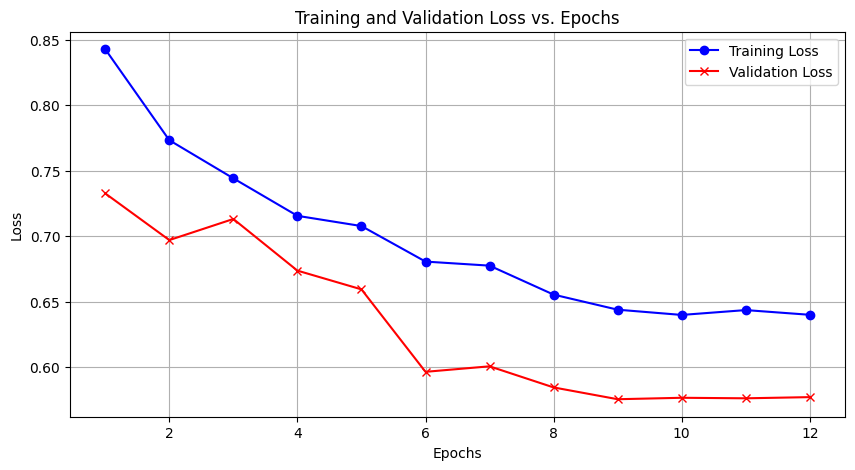

In [56]:
import matplotlib.pyplot as plt

# Replace these lists with your actual training and validation values from each epoch
train_losses = [
    0.8426, 0.7732, 0.7441, 0.7155, 0.7077, 0.6806, 0.6775, 0.6554, 0.6439, 0.6399, 
    0.6436, 0.6400
]
val_losses = [
    0.7326, 0.6970, 0.7131, 0.6737, 0.6594, 0.5965, 0.6007, 0.5846, 0.5756, 0.5767,
    0.5763, 0.5772
]

epochs = list(range(1, len(train_losses) + 1))

# Plotting loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='b')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, data_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Per-class metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=1)
    cm = confusion_matrix(all_labels, all_preds)

    return report, cm

# Example call with class names
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with your actual class names
report, cm = evaluate_model(model, valid_loader, device, class_names=class_names)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)



Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.98      0.91      2157
     Class 1       1.00      0.00      0.00       204
     Class 2       0.68      0.48      0.56       448
     Class 3       0.46      0.41      0.44        75
     Class 4       0.66      0.39      0.49        59

    accuracy                           0.81      2943
   macro avg       0.73      0.45      0.48      2943
weighted avg       0.81      0.81      0.77      2943

Confusion Matrix:
 [[2122    0   29    0    6]
 [ 189    0   14    0    1]
 [ 203    0  215   27    3]
 [   5    0   37   31    2]
 [   5    0   22    9   23]]


In [51]:
#Evaluation of the model

import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return precision, recall, f1, cm

# Example call using valid_loader for evaluation
precision, recall, f1, cm = evaluate_model(model, valid_loader, device)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

Precision: 0.7444016167070221
Recall: 0.8124362895005097
F1 Score: 0.7710046418186212
Confusion Matrix:
[[2122    0   29    0    6]
 [ 189    0   14    0    1]
 [ 203    0  215   27    3]
 [   5    0   37   31    2]
 [   5    0   22    9   23]]


/home/karannaik503/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
import torch
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class UnlabeledTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Add other formats if necessary
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_name


In [53]:

# Define the transformations
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Path to your test dataset
test_img_dir = "./Datasets/eye-q/test"  # Adjust this path if necessary

# Create a test dataset
test_dataset = UnlabeledTestDataset(img_dir=test_img_dir, transform=test_transforms)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [58]:
import pandas as pd
# Perform predictions on the test set and save results
model.eval()
image_names = []
predictions = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Remove the .jpeg extension from the image names
        img_names = [name.replace('.jpeg', '') for name in img_names]
        
        image_names.extend(img_names)
        predictions.extend(preds.cpu().numpy())

# Save test predictions to CSV
results_df = pd.DataFrame({
    "image": image_names,
    "level": predictions
})
results_df.to_csv("test_predictions-efficientnetB0.csv", index=False)
print("Test predictions saved to 'test_predictions-efficientnetB0.csv'")


Test predictions saved to 'test_predictions-efficientnetB0.csv'
